In [15]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv("C:\\Users\\admin\\Desktop\\GITHUB Projects\\UD\\store-sales-time-series-forecasting\\train.csv")
transactions = pd.read_csv("C:\\Users\\admin\\Desktop\\GITHUB Projects\\UD\\store-sales-time-series-forecasting\\transactions.csv")
stores = pd.read_csv("C:\\Users\\admin\\Desktop\\GITHUB Projects\\UD\\store-sales-time-series-forecasting\\stores.csv")

In [3]:
## Clean
df['date'] = pd.to_datetime(df['date'])
df['week'] = df['date'].dt.isocalendar().week
df['year'] = df['date'].dt.year
df['weekname'] = df.date.dt.day_name()
df['dayofyear'] = df['date'].dt.strftime('%j')
df['store_nbr'] = df['store_nbr'].astype(str) ## Didn't want the order of numbers to influence the model.

transactions['date'] = pd.to_datetime(transactions['date'])
transactions['store_nbr'] = transactions['store_nbr'].astype(str)
stores['store_nbr'] = stores['store_nbr'].astype(str)
stores['cluster'] = stores['cluster'].astype(str)
df = pd.merge(df, stores, on='store_nbr')
df = pd.merge(df, transactions, on=['store_nbr', 'date'])

In [4]:
## Organize
target = 'sales'
cat = [x for x in df.columns if df.dtypes[x] == 'object']
num = [x for x in df.columns if df.dtypes[x] in ('int64', 'float64')]
num.remove('id')
num.remove('sales')

In [5]:
## train test split
train = df.loc[df['date'].dt.year != 2017]
test = df.loc[df['date'].dt.year == 2017]

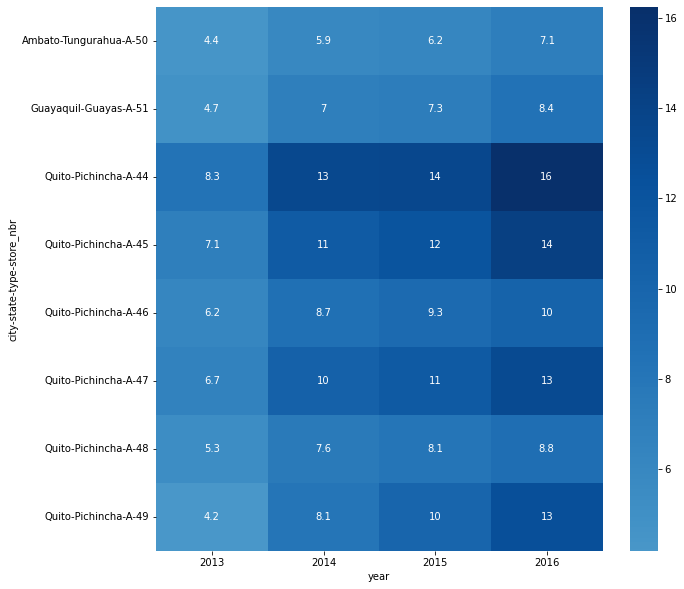

In [6]:
g = train.query('type=="A"')
g = g.pivot_table(target, index=['city', 'state', 'type', 'store_nbr'], columns='year', aggfunc='sum') /1000000
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(g, center=1, cmap='Blues', annot=True);

In [7]:
g = train.query('type=="A"')
g = g.groupby('family')[target].agg(['sum', 'std'])
g.sort_values(['sum'], ascending= False )
# fig, ax = plt.subplots(figsize=(10,10))
# sns.heatmap(g, center=1, cmap='Oranges', annot=True);

,sum,std
family,,
GROCERY I,8.775302e+07,3395.845389
BEVERAGES,5.717556e+07,3099.676652
PRODUCE,3.517733e+07,3618.258507
CLEANING,2.362948e+07,790.138897
DAIRY,1.909365e+07,806.316772
POULTRY,1.102969e+07,504.659631
BREAD/BAKERY,1.062232e+07,405.641033
MEATS,1.040025e+07,361.546946
PERSONAL CARE,6.354052e+06,307.390677


In [8]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer

class DataSelect(BaseEstimator, TransformerMixin):
    def __init__(self, att):
        self.att = att
    def fit(self, X, y=None):
        return self
    def transform(self, X, y=None):
        X['store_nbr'] = X['store_nbr'].astype(str)
        return X[self.att]

In [12]:
num_pp = Pipeline([
    ('dataselect', DataSelect(['onpromotion']))
    , ('impute', SimpleImputer(strategy='median'))
    , ('scaler', StandardScaler())
])

cat_pp = Pipeline([
    ('dataselect', DataSelect(['family', 'store_nbr']))
    , ('encoder', OneHotEncoder(handle_unknown='ignore'))
])

pipe = FeatureUnion([
    ('numeric', num_pp)
    , ('cat', cat_pp)
])

pipe.fit(train)
train_pp = pipe.transform(train)
test_pp = pipe.transform(test)

C:\Users\admin\AppData\Local\Temp\ipykernel_12436\3426257542.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['store_nbr'] = X['store_nbr'].astype(str)
C:\Users\admin\AppData\Local\Temp\ipykernel_12436\3426257542.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['store_nbr'] = X['store_nbr'].astype(str)
C:\Users\admin\AppData\Local\Temp\ipykernel_12436\3426257542.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_index

In [13]:
from sklearn.linear_model import LinearRegression
from sklearn.svm import LinearSVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score

In [14]:
reg_lin = LinearRegression()
reg_lin.fit(train_pp, train[target])
np.sqrt(
    -cross_val_score(
        reg_lin, train_pp, train[target], scoring='neg_mean_squared_error').mean()
)

750.0265592523879

In [17]:
samp = pd.read_csv("C:\\Users\\admin\\Desktop\\GITHUB Projects\\UD\\store-sales-time-series-forecasting\\test.csv")
pd.DataFrame({
    'id': samp['id']
    , 'sales': reg_lin.predict(pipe.transform(samp))
}).to_csv("C:\\Users\\admin\\Desktop\\GITHUB Projects\\UD\\store-sales-time-series-forecasting\\submission.csv", index=False)